In [1]:
import mesh2sdf
import numpy as np
import pandas as pd
from skimage import measure
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('../../ShapeNetCore.v2/paths_32.csv', sep=' ', names=['path', 'class'])
df

,path,class
0,/home/justwantpost/drive/ShapeNetCore.v2/02773...,1
1,/home/justwantpost/drive/ShapeNetCore.v2/02773...,1
2,/home/justwantpost/drive/ShapeNetCore.v2/02773...,1
3,/home/justwantpost/drive/ShapeNetCore.v2/02773...,1
4,/home/justwantpost/drive/ShapeNetCore.v2/02773...,1
...,...,...
52467,/home/justwantpost/drive/ShapeNetCore.v2/03325...,1
52468,/home/justwantpost/drive/ShapeNetCore.v2/03325...,1
52469,/home/justwantpost/drive/ShapeNetCore.v2/03325...,1
52470,/home/justwantpost/drive/ShapeNetCore.v2/03325...,1


In [3]:
for path in tqdm(df['path']):
    sdf = np.load(path)
    level = 2 / sdf.shape[0]
    # print(sdf.min(), sdf.max(), level)
    vertices, faces, normals, _ = measure.marching_cubes(sdf, level=level)


  0%|          | 0/52472 [00:00<?, ?it/s]

In [4]:
maxes = []
mins = []

for path in tqdm(df['path']):
    sdf = np.load(path)
    maxes.append(sdf.max())
    mins.append(sdf.min())

  0%|          | 0/52472 [00:00<?, ?it/s]

In [7]:
max(maxes)

1.9403013

In [8]:
min(mins)

-0.86058086

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define constants
tubelet_size = 2
crop_size = 32
in_channels = 1
num_frames = 32
patch_size = 4
num_masks = num_frames // tubelet_size
alpha = 0.5 # for overlaying masks
# Define colors for masks
colors = [
    [1, 0, 0],  # Red
    [0, 1, 0],  # Green
    [0, 0, 1],  # Blue
    [1, 1, 0],  # Yellow
    [1, 0, 1],  # Magenta
    [0, 1, 1],  # Cyan
    [0.5, 0.5, 0.5],  # Gray
    [1, 0.5, 0],  # Orange
]
CLIP_NUM = 0

In [2]:
# Load tensors from the file tensors.pth
loaded_tensors = torch.load('tensors_sdf.pth', map_location='cpu')
clips = loaded_tensors['tensor1']
masks_enc = loaded_tensors['tensor2']
masks_pred = loaded_tensors['tensor3']

FileNotFoundError: [Errno 2] No such file or directory: 'tensors_sdf.pth'

In [67]:
print('clips', clips.size())
print('masks_enc', len(masks_enc), masks_enc[0].size())
print('masks_pred', len(masks_pred), masks_pred[0].size())

clips torch.Size([4, 1, 32, 32, 32])
masks_enc 2 torch.Size([4, 320])
masks_pred 2 torch.Size([4, 512])


In [87]:
read_one_clip = False

if read_one_clip:
    one_clip = torch.load('one_clip.pt', map_location='cpu')
    print('one clip', one_clip.size())
    plt.imshow(one_clip[0])
    plt.show()
else:
    # Load tensors from the file tensors.pth
    loaded_tensors = torch.load('tensors_sdf.pth', map_location='cpu')
    clips = loaded_tensors['tensor1']
    print('clips', clips.size())
    # 3x16x224x224 -> 16x224x224x3
    one_clip = clips[CLIP_NUM].permute(1, 2, 3, 0).squeeze()
    print('one clip', one_clip.size())

# Load masks from the file
masks_list = torch.load('masks_sdf.pt', map_location='cpu')
masks_list = [mask.squeeze() for mask in masks_list]
print('masks', len(masks_list), 'of size', masks_list[0].shape)

clips torch.Size([4, 1, 32, 32, 32])
one clip torch.Size([32, 32, 32])
masks 8 of size torch.Size([16, 8, 8])


In [88]:
def create_mask_for_original_tensor(mask, original_shape, tubelet_size=2, patch_size=16):
    original_mask = torch.ones(original_shape)
    _, H, W = mask.shape

    # Iterate over the mask tensor to identify zeroed patches
    for t in range(mask.shape[0]):
        for h in range(H):
            for w in range(W):
                if mask[t, h, w] == 0:
                    # Calculate the corresponding indices in the original tensor
                    t_start = t * tubelet_size
                    t_end = t_start + tubelet_size
                    h_start = h * patch_size
                    h_end = h_start + patch_size
                    w_start = w * patch_size
                    w_end = w_start + patch_size
                    
                    original_mask[t_start:t_end, h_start:h_end, w_start:w_end] = 0
    return original_mask

In [5]:
import numpy as np
from skimage import measure
import open3d as o3d

def sdf2mesh(sdf, view=False, save=False, level=0):
    # Use marching cubes to obtain the surface mesh
    vertices, faces, normals, _ = measure.marching_cubes(sdf, level=level)

    # Create an Open3D mesh object
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)

    # compute vertex normals
    mesh.compute_vertex_normals()

    # Save the mesh to an .obj file
    if save:
        o3d.io.write_triangle_mesh('output_mesh.obj', mesh)

    # (Optional) Visualize the mesh
    if view:
        o3d.visualization.draw_geometries([mesh])
        
    return mesh

In [121]:
def visualize_frames_with_black_mask(one_clip, original_mask):

    original_mask = (original_mask).int()
    one_clip[original_mask == 0] = 1e6
    masked_frame = one_clip.numpy() # 32x32x32
    
    sdf2mesh(masked_frame, False, True)

In [122]:
whole_mask = torch.ones_like(masks_list[0])
for mask in masks_list:
    whole_mask *= mask

original_mask = create_mask_for_original_tensor(whole_mask, one_clip.shape, tubelet_size, patch_size)
visualize_frames_with_black_mask(one_clip, original_mask)

[Open3D WARNING] Write OBJ can not include triangle normals.


Original tensor: tensor([0, 1, 0, 1, 1, 0])
Inverted tensor: tensor([1, 0, 1, 0, 0, 1])


In [ ]:
def visualize_frames_with_colored_masks(one_clip, list_of_original_masks, colors, alpha=0.3, tubelet_size=2, in_channels=3, num_frames=16):
    # Create a figure to visualize the frames
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))

    # Plot frames from clips with the corresponding masks
    for i in range(num_frames):
        frame = one_clip[i].numpy()
        
        # Plot the original frame
        ax = axes[i // 4, i % 4]
        ax.imshow(frame)
        ax.set_title(f'Frame {i}')
        ax.axis('off')
        
        # Overlay each mask with its own color
        for mask_idx, original_mask in enumerate(list_of_original_masks):
            mask_frame_idx = i // tubelet_size  # Adjust the frame index for the mask
            if mask_frame_idx < original_mask.shape[0]:
                mask_np = original_mask[mask_frame_idx].numpy()[:, :, 0]  # Extract the mask for a single frame

                # Create an RGBA image with the mask color
                colored_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 4)) # 4 is for RGBA channels
                for j in range(in_channels):
                    colored_mask[:, :, j] = mask_np * colors[mask_idx][j]
                colored_mask[:, :, 3] = mask_np * alpha  # Set alpha channel based on the mask and provided alpha
                
                ax.imshow(colored_mask)  # Overlay the mask

    plt.tight_layout()
    plt.show()


IndexError: index 4 is out of bounds for axis 0 with size 4

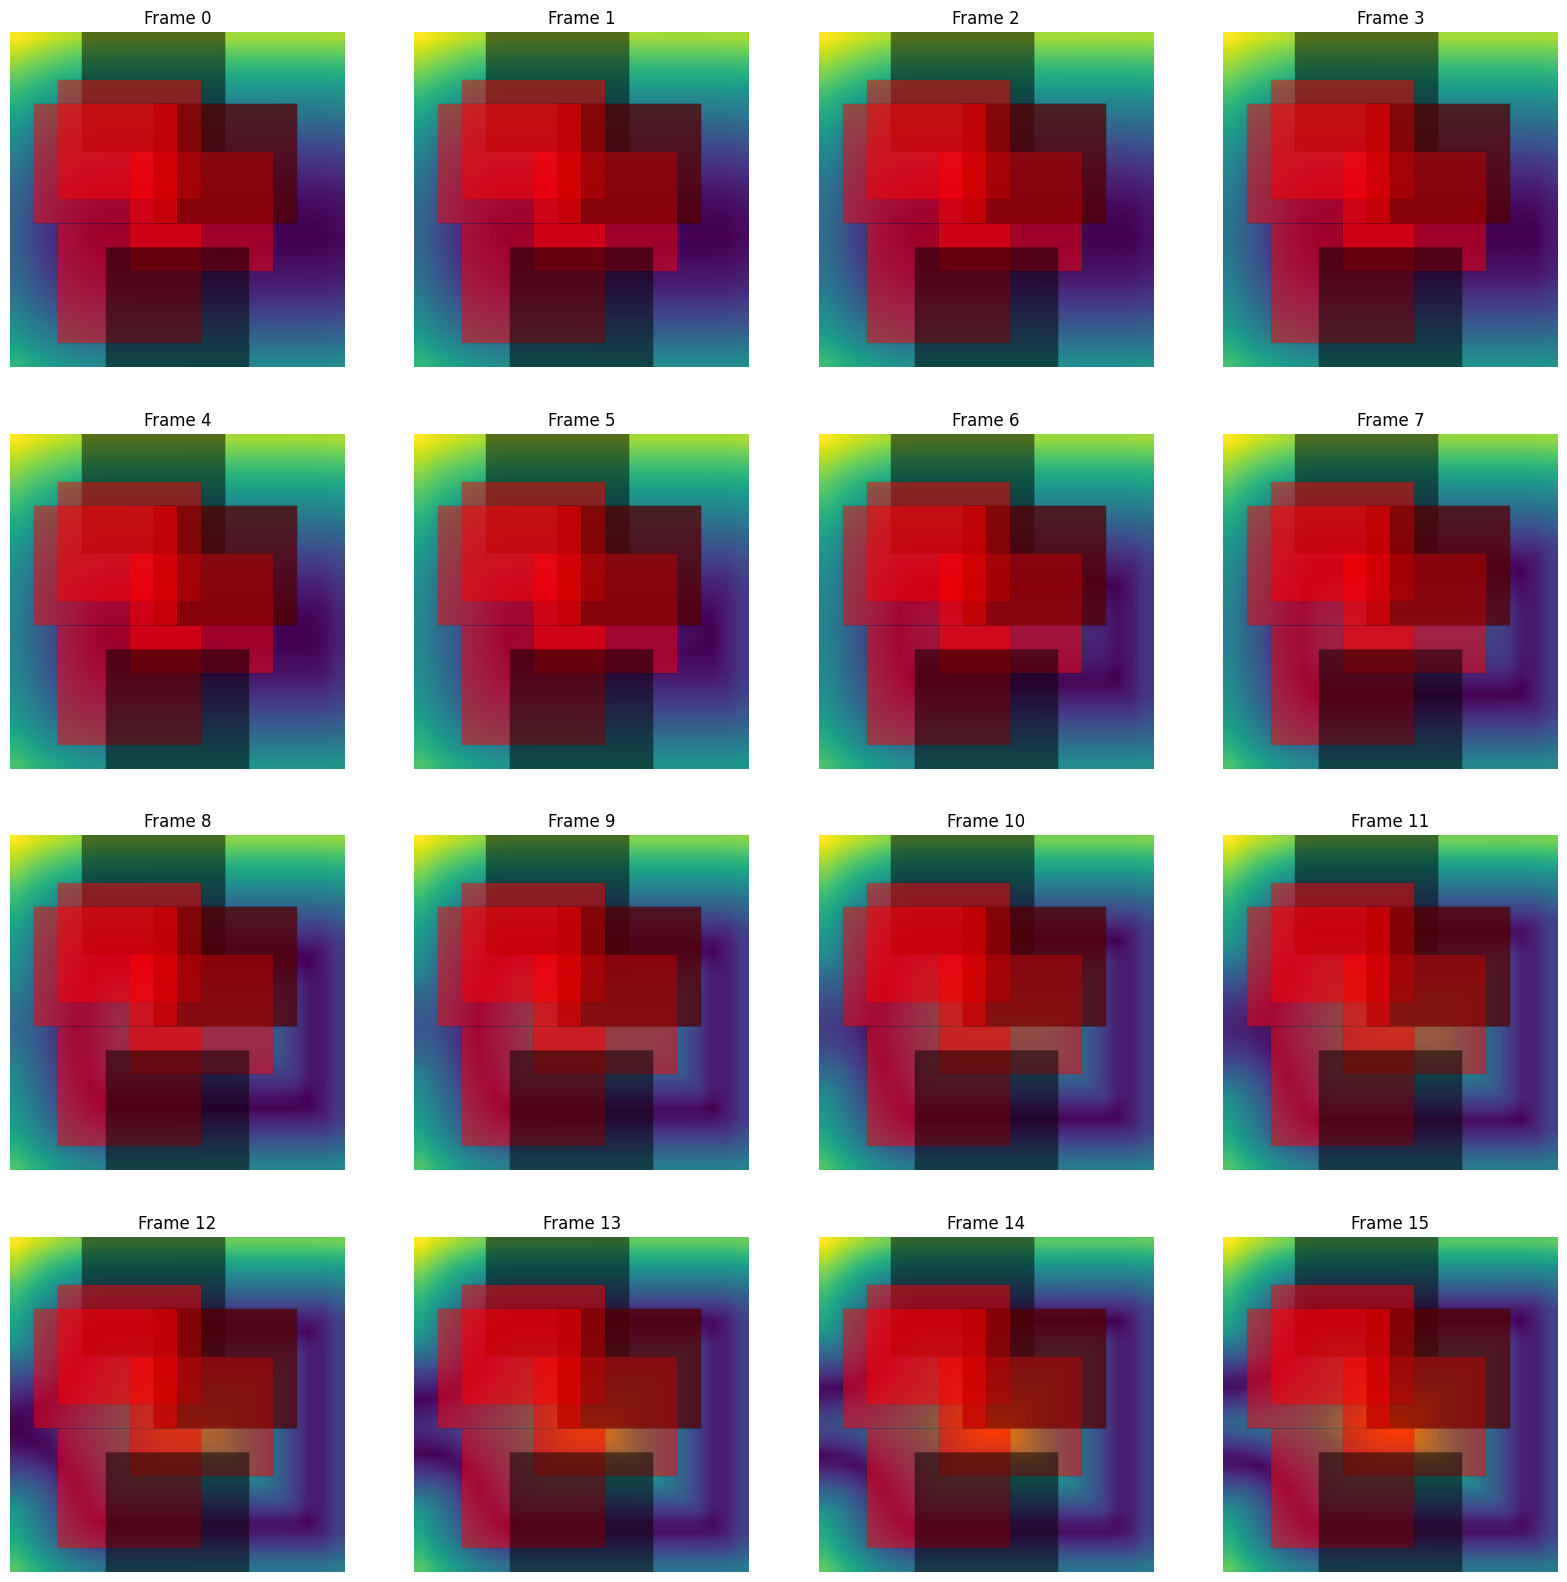

In [19]:
# Visualize the frames and masks
# (1 - x) is done for visualization only
visualize_frames_with_colored_masks(one_clip, 
                                    [1 - create_mask_for_original_tensor(mask, one_clip.shape, tubelet_size, patch_size) for mask in masks_list],
                                    colors, 
                                    alpha, tubelet_size, in_channels, num_frames
)